In [ ]:
import os
import json
import shutil
import gc
import torch
from transformers import AutoModelForCausalLM
from tqdm import tqdm
import matplotlib.pyplot as plt

CACHE_DIR = "/shared/storage-01/huggingface/models/"
OUTPUT_ROOT = "rank_results_all_models"

MODEL_PAIRS = [
    {
        "tag": "dpo_llama_3_1_tulu_3_8b",
        "sft": "allenai/Llama-3.1-Tulu-3-8B-SFT",
        "rl": "allenai/Llama-3.1-Tulu-3-8B-DPO",
    },
    {
        "tag": "grpo_deepseek_math_7b",
        "sft": "deepseek-ai/deepseek-math-7b-instruct",
        "rl": "deepseek-ai/deepseek-math-7b-rl",
    },
    {
        "tag": "orpo_mistral_7b_v0_1",
        "sft": "mistralai/Mistral-7B-v0.1",
        "rl": "kaist-ai/mistral-orpo-beta",
    },
    {
        "tag": "kto_eurus_7b",
        "sft": "openbmb/Eurus-7b-sft",
        "rl": "openbmb/Eurus-7b-kto",
    },
    {
        "tag": "kto_llama_3_base_8b",
        "sft": "princeton-nlp/Llama-3-Base-8B-SFT",
        "rl": "princeton-nlp/Llama-3-Base-8B-SFT-KTO",
    },
    {
        "tag": "ppo_mistral_7b_math_shepherd",
        "sft": "peiyi9979/mistral-7b-sft",
        "rl": "peiyi9979/math-shepherd-mistral-7b-rl",
    },
    #{
        #"tag": "simpo_llama_3_instruct_8b",
        #"sft": "meta-llama/Meta-Llama-3-8B-Instruct",
        #"rl": "princeton-nlp/Llama-3-Instruct-8B-SimPO",
    #},
    {
        "tag": "prime_eurus_2_7b",
        "sft": "PRIME-RL/Eurus-2-7B-SFT",
        "rl": "PRIME-RL/Eurus-2-7B-PRIME",
    },
]

def _to2d(x):
    if x.ndim == 2:
        return x
    return x.reshape(x.shape[0], -1)

def _sv(x2d):
    return torch.linalg.svdvals(x2d.float().cpu())

def _energy_rank(s, eps):
    if s.numel() == 0:
        return 0
    e = s**2
    cum = torch.cumsum(e, 0)
    total = cum[-1]
    if total <= 0:
        return 0
    target = (1.0 - eps) * total
    k = int(torch.searchsorted(cum, target).item()) + 1
    return min(k, s.numel())

def _effective_rank(s, tiny=1e-12):
    if s.numel() == 0:
        return 0.0
    p = s / (s.sum() + tiny)
    p = torch.clamp(p, min=tiny)
    H = -(p * torch.log(p)).sum()
    return float(torch.exp(H).item())

def _stable_rank(s, tiny=1e-12):
    if s.numel() == 0:
        return 0.0
    num = float((s**2).sum().item())
    den = float((s.max().item() ** 2) + tiny)
    return num / den

def _energy_curve(s):
    if s.numel() == 0:
        return None, None
    e = s**2
    cum = torch.cumsum(e, 0)
    frac = cum / (cum[-1] + 1e-12)
    k = torch.arange(1, s.numel() + 1)
    return k, frac

def clear_repo_cache(cache_dir, repo_id):
    if "/" not in repo_id:
        return
    org, name = repo_id.split("/", 1)
    path = os.path.join(cache_dir, f"models--{org}--{name}")
    if os.path.isdir(path):
        shutil.rmtree(path, ignore_errors=True)

def run_pair(sft_model, rl_model, out_dir):
    os.makedirs(out_dir, exist_ok=True)
    plot_dir = os.path.join(out_dir, "rank_plots")
    os.makedirs(plot_dir, exist_ok=True)

    model_sft = AutoModelForCausalLM.from_pretrained(
        sft_model,
        torch_dtype=torch.bfloat16,
        device_map="cpu",
        cache_dir= CACHE_DIR,
    )
    model_rl = AutoModelForCausalLM.from_pretrained(
        rl_model,
        torch_dtype=torch.bfloat16,
        device_map="cpu",
        cache_dir= CACHE_DIR,
    )

    rl_state_dict = model_rl.state_dict()
    sft_state_dict = model_sft.state_dict()

    for name_sft, _ in tqdm(model_sft.named_parameters(), desc="check_sft"):
        if name_sft not in rl_state_dict:
            print("missing in rl:", name_sft)
    for name_rl, _ in tqdm(model_rl.named_parameters(), desc="check_rl"):
        if name_rl not in sft_state_dict:
            print("missing in sft:", name_rl)

    eps_list = [1e-1, 5e-2, 1e-2, 1e-3]
    max_rank_list = []
    rank_list = []
    layer_metrics = {}

    with torch.no_grad():
        for key, param_sft in tqdm(model_sft.named_parameters(), desc="layers"):
            if "layernorm" in key or len(param_sft.shape) <= 1:
                continue
            try:
                param_rl = rl_state_dict[key].to(param_sft.device)
                A = _to2d(param_rl - param_sft.data)
                s = _sv(A)
                rank_ = int(torch.linalg.matrix_rank(A.float()).item())
                max_rank_ = min(A.shape)
                max_rank_list.append(max_rank_)
                rank_list.append(rank_)
                enr = {str(eps): _energy_rank(s, eps) for eps in eps_list}
                effr = _effective_rank(s)
                stabr = _stable_rank(s)
                layer_metrics[key] = {
                    "shape_2d": list(A.shape),
                    "max_rank": max_rank_,
                    "exact_rank": rank_,
                    "effective_rank": effr,
                    "stable_rank": stabr,
                    "energy_rank": enr,
                }
                k, frac = _energy_curve(s)
                if k is not None:
                    plt.figure()
                    plt.plot(k.numpy(), frac.numpy())
                    plt.xlabel("rank")
                    plt.ylabel("normalized energy retained")
                    plt.ylim(0, 1.01)
                    plt.title(key)
                    for eps in eps_list:
                        ek = enr[str(eps)]
                        plt.axvline(ek, linestyle="--", alpha=0.5)
                    plt.tight_layout()
                    plt.savefig(os.path.join(plot_dir, key.replace("/", "_") + ".png"), dpi=150)
                    plt.close()
                print(out_dir, layer_metrics[key])
            except Exception as e:
                print("error processing layer", key, e)

    mean = sum(y / x for x, y in zip(max_rank_list, rank_list)) / len(max_rank_list)
    print("mean rank fraction", mean)

    metrics_path = os.path.join(out_dir, "layer_rank_metrics.json")
    with open(metrics_path, "w") as f:
        json.dump(layer_metrics, f, indent=2)

    del model_sft
    del model_rl
    del rl_state_dict
    del sft_state_dict
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

os.makedirs(OUTPUT_ROOT, exist_ok=True)

for pair in MODEL_PAIRS:
    out_dir = os.path.join(OUTPUT_ROOT, pair["tag"])
    print("running", pair["tag"])
    run_pair(pair["sft"], pair["rl"], out_dir)
    clear_repo_cache(CACHE_DIR, pair["sft"])
    clear_repo_cache(CACHE_DIR, pair["rl"])



In [2]:
import json, re, os
import numpy as np
import matplotlib.pyplot as plt

ROOT = "rank_results_all_models"

MODEL_TAGS = [
    "dpo_llama_3_1_tulu_3_8b",
    "grpo_deepseek_math_7b",
    "orpo_mistral_7b_v0_1",
    "kto_eurus_7b",
    "kto_llama_3_base_8b",
    "ppo_mistral_7b_math_shepherd",
    #"simpo_llama_3_instruct_8b",
    #"prime_eurus_2_7b",
]

def layer_idx(name):
    m = re.search(r"model\.layers\.(\d+)\.", name)
    return int(m.group(1)) if m else None

def layer_type(name):
    if ".self_attn.q_proj." in name: return "Q"
    if ".self_attn.k_proj." in name: return "K"
    if ".self_attn.v_proj." in name: return "V"
    if ".self_attn.o_proj." in name: return "O"
    if ".mlp.gate_proj." in name: return "GATE"
    if ".mlp.up_proj." in name: return "UP"
    if ".mlp.down_proj." in name: return "DOWN"
    return None

for tag in MODEL_TAGS:
    metrics_path = os.path.join(ROOT, tag, "layer_rank_metrics.json")
    if not os.path.exists(metrics_path):
        print("missing", metrics_path)
        continue

    with open(metrics_path, "r") as f:
        layer_metrics = json.load(f)

    flat = {}
    for name, d in layer_metrics.items():
        i = layer_idx(name)
        t = layer_type(name)
        if i is None or t is None:
            continue
        base = {
            "max_rank": d["max_rank"],
            "exact_rank": d["exact_rank"],
            "exact_rank_ratio": d["exact_rank"] / (d["max_rank"] + 1e-12),
            "effective_rank": d["effective_rank"],
            "stable_rank": d["stable_rank"],
        }
        enr = d.get("energy_rank", {})
        for eps_str, k in enr.items():
            base[f"energy_rank_eps={eps_str}"] = k
            base[f"energy_rank_ratio_eps={eps_str}"] = k / (d["max_rank"] + 1e-12)
        flat.setdefault(t, []).append((i, base))

    types = sorted(flat.keys())
    if not types:
        print("no recognized layers for", tag)
        continue

    metrics_keys = sorted({k for t in types for _, b in flat[t] for k in b.keys()})

    out_dir = os.path.join(ROOT, tag, "metric_vs_depth_plots")
    os.makedirs(out_dir, exist_ok=True)

    for mk in metrics_keys:
        plt.figure()
        for t in types:
            items = sorted(flat[t], key=lambda x: x[0])
            xs = [i for i, _ in items]
            ys = [b[mk] for _, b in items]
            plt.plot(xs, ys, label=t)
        plt.xlabel("depth (layer index)")
        plt.ylabel(mk)
        plt.title(mk + " vs depth")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, mk.replace("/", "_") + ".png"), dpi=150)
        plt.close()

    print("saved ->", out_dir)


saved -> rank_results_all_models/dpo_llama_3_1_tulu_3_8b/metric_vs_depth_plots
saved -> rank_results_all_models/grpo_deepseek_math_7b/metric_vs_depth_plots
saved -> rank_results_all_models/orpo_mistral_7b_v0_1/metric_vs_depth_plots
saved -> rank_results_all_models/kto_eurus_7b/metric_vs_depth_plots
saved -> rank_results_all_models/kto_llama_3_base_8b/metric_vs_depth_plots
saved -> rank_results_all_models/ppo_mistral_7b_math_shepherd/metric_vs_depth_plots


available metrics: ['energy_rank_ratio_eps=0.05', 'energy_rank_eps=0.1', 'exact_rank_ratio', 'effective_rank', 'energy_rank_ratio_eps=0.01', 'stable_rank', 'max_rank', 'energy_rank_ratio_eps=0.1', 'exact_rank', 'energy_rank_eps=0.001', 'energy_rank_eps=0.01', 'energy_rank_ratio_eps=0.001', 'energy_rank_eps=0.05']
using metric: energy_rank_ratio_eps=0.1
missing image: rank_results_all_models/simpo_llama_3_instruct_8b/metric_vs_depth_plots/energy_rank_ratio_eps=0.1.png
missing image: rank_results_all_models/prime_eurus_2_7b/metric_vs_depth_plots/energy_rank_ratio_eps=0.1.png
saved -> rank_results_all_models/combined_energy_rank_ratio_eps=0.1.png


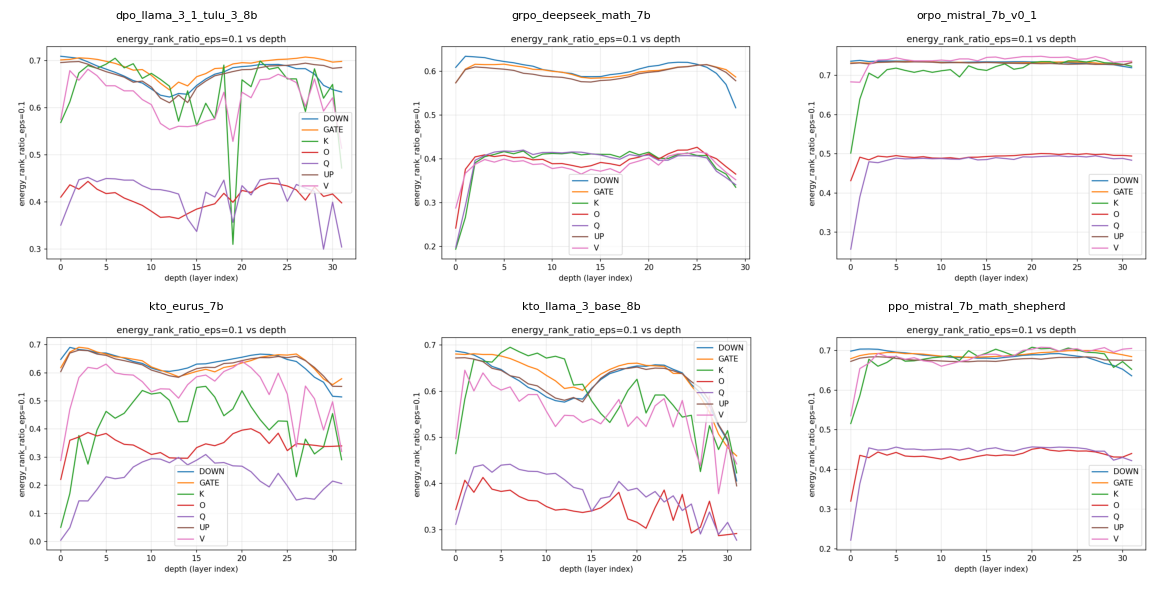

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt

ROOT = "rank_results_all_models"

MODEL_TAGS = [
    "dpo_llama_3_1_tulu_3_8b",
    "grpo_deepseek_math_7b",
    "orpo_mistral_7b_v0_1",
    "kto_eurus_7b",
    "kto_llama_3_base_8b",
    "ppo_mistral_7b_math_shepherd",
    "simpo_llama_3_instruct_8b",
    "prime_eurus_2_7b",
]

def discover_metrics():
    for tag in MODEL_TAGS:
        folder = os.path.join(ROOT, tag, "metric_vs_depth_plots")
        if not os.path.isdir(folder):
            continue
        files = os.listdir(folder)
        metrics = [
            f.replace(".png", "")
            for f in files
            if f.endswith(".png")
        ]
        if metrics:
            print("available metrics:", metrics)
            return metrics
    raise RuntimeError("no metrics found in any model folder")

ALL_METRICS = discover_metrics()

METRIC_KEY = ALL_METRICS[7]
print("using metric:", METRIC_KEY)

metric_filename = METRIC_KEY + ".png"

paths = []
labels = []

for tag in MODEL_TAGS:
    img_path = os.path.join(ROOT, tag, "metric_vs_depth_plots", metric_filename)
    if os.path.exists(img_path):
        paths.append(img_path)
        labels.append(tag)
    else:
        print("missing image:", img_path)

if not paths:
    raise SystemExit("no images found for selected metric")

n = len(paths)
ncols = 3
nrows = int(np.ceil(n / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
axes = np.array(axes).reshape(-1)

for ax, path, label in zip(axes, paths, labels):
    img = plt.imread(path)
    ax.imshow(img)
    ax.set_title(label, fontsize=8)
    ax.axis("off")

for ax in axes[len(paths):]:
    ax.axis("off")

plt.tight_layout()
out_path = os.path.join(ROOT, f"combined_{METRIC_KEY}.png")
plt.savefig(out_path, dpi=150)
print("saved ->", out_path)
plt.show()
